In [4]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scienceplots
from shapely.geometry import Polygon
from rasterio.features import geometry_mask
import json
import os
import glob

plt.style.use('science')
def process_granule(granule_path):
    """
    Processes a Sentinel-2 granule and returns metrics over a masked area.

    Parameters:
    - granule_path: str, path to the GRANULE folder

    Returns:
    - metrics_json: str, JSON object containing the computed metrics
    """
    # Find the band files in the granule path
    # Assuming the structure is as per Sentinel-2 data
    img_data_path = os.path.join(granule_path, 'IMG_DATA', 'R10m')
    if not os.path.exists(img_data_path):
        raise FileNotFoundError(f"Image data path does not exist: {img_data_path}")

    # Find the files for each band
    band_files = {}
    for band_code in ['AOT', 'B02', 'B03', 'B04', 'B08', 'TCI', 'WVP']:
        search_pattern = os.path.join(img_data_path, f'*_{band_code}_10m.jp2')
        band_file_list = glob.glob(search_pattern)
        if band_file_list:
            band_files[band_code] = band_file_list[0]  # Take the first match
        else:
            print(f"Band {band_code} not found in {img_data_path}")

    # Check that necessary bands are found
    required_bands = ['B02', 'B03', 'B04', 'B08']
    for band in required_bands:
        if band not in band_files:
            raise ValueError(f"Required band {band} not found in granule.")

    # Initialize storage for masked bands
    masked_bands = {}
    unmasked_bands = {}
    mask = None  # To store the mask for later use

    window_size = 1000  # Fixed window size

    # Read the first band to get the transform and dimensions
    first_band_path = band_files[required_bands[0]]
    with rasterio.open(first_band_path) as src:
        # Zoom into the dataset (center with a predefined window)
        center_x, center_y = src.width // 2, src.height // 2
        window = rasterio.windows.Window(
            center_x - window_size // 2,
            center_y - window_size // 2,
            window_size,
            window_size
        )
        zoomed_transform = src.window_transform(window)
        # Read the data for visualization
        # No need to read band_data here, we'll read it for each band

    # Use the polygon_coords provided
    polygon_coords = [
        (428.0714285714286, 780.3441558441558),
        (426.44805194805207, 827.422077922078),
        (470.2792207792209, 825.7987012987013),
        (501.1233766233767, 825.7987012987013),
        (543.331168831169, 825.7987012987013),
        (543.331168831169, 809.5649350649351),
        (543.331168831169, 790.0844155844156),
        (543.331168831169, 773.8506493506493),
        (499.50000000000006, 772.2272727272727),
        (458.91558441558453, 773.8506493506493),
        (428.0714285714286, 780.3441558441558)
    ]

    # Convert pixel coordinates to map coordinates using the transform
    polygon_coords_map = [zoomed_transform * (x, y) for x, y in polygon_coords]
    polygon = Polygon(polygon_coords_map)

    # Create the mask
    mask = geometry_mask(
        [polygon],
        transform=zoomed_transform,
        invert=True,
        out_shape=(window.height, window.width)
    )

    # Read all bands, apply the mask, and store them
    for band_name, band_path in band_files.items():
        with rasterio.open(band_path) as src:
            band_data_unmasked = src.read(1, window=window).astype('float32')
            # Save unmasked band data for background
            unmasked_bands[band_name] = band_data_unmasked / 10000.0  # Scale reflectance
            # Apply mask
            masked_band = np.where(mask, band_data_unmasked, np.nan)
            masked_bands[band_name] = masked_band / 10000.0  # Scale reflectance

    # Compute indices and metrics
    metrics = {}

    if "B08" in masked_bands and "B04" in masked_bands:
        nir = masked_bands["B08"]
        red = masked_bands["B04"]

        ndvi = (nir - red) / (nir + red)
        ndvi_mask = ndvi  # Already masked

        # Calculate NDVI statistics
        ndvi_mean = np.nanmean(ndvi_mask)
        ndvi_min = np.nanmin(ndvi_mask)
        ndvi_max = np.nanmax(ndvi_mask)
        ndvi_std = np.nanstd(ndvi_mask)

        metrics["ndvi"] = {
            "mean": float(ndvi_mean),
            "min": float(ndvi_min),
            "max": float(ndvi_max),
            "std": float(ndvi_std)
        }
    else:
        ndvi_mask = None

    # NDMI calculation
    if "B08" in masked_bands and "WVP" in masked_bands:
        nir = masked_bands["B08"]
        swir = masked_bands["WVP"]
        ndmi = (nir - swir) / (nir + swir)
        ndmi_mask = ndmi  # Already masked

        # Calculate NDMI statistics
        ndmi_mean = np.nanmean(ndmi_mask)
        ndmi_min = np.nanmin(ndmi_mask)
        ndmi_max = np.nanmax(ndmi_mask)
        ndmi_std = np.nanstd(ndmi_mask)

        metrics["ndmi"] = {
            "mean": float(ndmi_mean),
            "min": float(ndmi_min),
            "max": float(ndmi_max),
            "std": float(ndmi_std)
        }
    else:
        ndmi_mask = None

    # SAVI calculation
    if "B08" in masked_bands and "B04" in masked_bands:
        L = 0.5  # Soil brightness correction factor
        savi = ((nir - red) / (nir + red + L)) * (1 + L)
        savi_mask = savi  # Already masked
        savi_mean = np.nanmean(savi_mask)
        savi_min = np.nanmin(savi_mask)
        savi_max = np.nanmax(savi_mask)
        savi_std = np.nanstd(savi_mask)

        metrics["savi"] = {
            "mean": float(savi_mean),
            "min": float(savi_min),
            "max": float(savi_max),
            "std": float(savi_std)
        }
    else:
        savi_mask = None

    # EVI calculation
    if "B08" in masked_bands and "B04" in masked_bands and "B02" in masked_bands:
        blue = masked_bands["B02"]
        evi = 2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1)
        evi_mask = evi  # Already masked
        evi_mean = np.nanmean(evi_mask)
        evi_min = np.nanmin(evi_mask)
        evi_max = np.nanmax(evi_mask)
        evi_std = np.nanstd(evi_mask)

        metrics["evi"] = {
            "mean": float(evi_mean),
            "min": float(evi_min),
            "max": float(evi_max),
            "std": float(evi_std)
        }
    else:
        evi_mask = None
        
        # GNDVI calculation
    if "B08" in masked_bands and "B03" in masked_bands:
        nir = masked_bands["B08"]
        green = masked_bands["B03"]
        gndvi = (nir - green) / (nir + green)
        gndvi_mask = gndvi  # Already masked

        # Calculate GNDVI statistics
        gndvi_mean = np.nanmean(gndvi_mask)
        gndvi_min = np.nanmin(gndvi_mask)
        gndvi_max = np.nanmax(gndvi_mask)
        gndvi_std = np.nanstd(gndvi_mask)
        gndvi_percentiles = np.nanpercentile(gndvi_mask, [25, 50, 75])

        metrics["gndvi"] = {
            "mean": float(gndvi_mean),
            "min": float(gndvi_min),
            "max": float(gndvi_max),
            "std": float(gndvi_std),
            "percentiles": {
                "25th": float(gndvi_percentiles[0]),
                "50th": float(gndvi_percentiles[1]),
                "75th": float(gndvi_percentiles[2])
            }
        }
    else:
        gndvi_mask = None


    # Compute field area
    field_pixels = np.count_nonzero(~np.isnan(masked_bands["B08"]))
    pixel_area = 10 * 10  # Sentinel-2 resolution for 10m bands (m² per pixel)
    field_area_m2 = field_pixels * pixel_area
    field_area_ha = field_area_m2 / 10_000  # Convert to hectares

    metrics["field_area"] = {
        "pixels": int(field_pixels),
        "square_meters": field_area_m2,
        "hectares": field_area_ha
    }

    # Create a figure with subplots showing all the bands and indices
    band_names_to_plot = ["B02", "B03", "B04", "B08", "TCI", "WVP"]
    indices_to_plot = {"NDVI": ndvi_mask, "NDMI": ndmi_mask, "SAVI": savi_mask, "EVI": evi_mask}

    num_bands = len(band_names_to_plot)
    num_indices = len(indices_to_plot)

    max_plots = max(num_bands, num_indices)
    fig, axes = plt.subplots(2, max_plots, figsize=(5 * max_plots, 10))

    # Plot bands
    for i, band_name in enumerate(band_names_to_plot):
        ax = axes[0, i]
        # Get unmasked and masked band data
        unmasked_band = unmasked_bands[band_name]
        masked_band = masked_bands[band_name]

        # Create background by masking the area inside the polygon
        background = unmasked_band.copy()
        background[mask] = np.nan  # Masked area is transparent in background

        # Display background
        ax.imshow(background, cmap='magma', alpha=0.4)

        # Overlay the masked area with higher opacity
        ax.imshow(masked_band, cmap='magma', alpha=1)
        ax.set_title(f"{band_name} Band")
        ax.axis('on')
    # Plot indices
    index_names = list(indices_to_plot.keys())
    for i, index_name in enumerate(index_names):
        index_data = indices_to_plot[index_name]
        if index_data is not None:
            ax = axes[1, i]
            # Create background by masking the area inside the polygon
            # For indices, background can be the unmasked NDVI or another band
            # Here, we'll use unmasked NDVI if available, otherwise use a band
            if ndvi_mask is not None:
                unmasked_index = (unmasked_bands["B08"] - unmasked_bands["B04"]) / (unmasked_bands["B08"] + unmasked_bands["B04"])
            else:
                unmasked_index = unmasked_bands["B08"]  # Use NIR band as background

            background = unmasked_index.copy()
            background[mask] = np.nan  # Masked area is transparent in background

            # Display background
            ax.imshow(background, cmap='viridis', alpha=0.4)

            # Overlay the masked area with higher opacity
            ax.imshow(index_data, cmap='viridis', alpha=1)
            ax.set_title(f"{index_name}")
            ax.axis('on')

    # Remove empty subplots if any
    for i in range(len(index_names), max_plots):
        fig.delaxes(axes[1, i])

    plt.tight_layout()
    plt.savefig('output_figure.png')
    plt.show()
    
    # NDVI histogram
    plt.figure(figsize=(10, 6))
    plt.hist(ndvi_mask[~np.isnan(ndvi_mask)], bins=50, color='green', alpha=0.7, label = 'NDVI')
    plt.hist(ndmi_mask[~np.isnan(ndmi_mask)], bins=50, color='blue', alpha=0.7, label = 'NDMI')
    plt.hist(savi_mask[~np.isnan(savi_mask)], bins=50, color='red', alpha=0.7, label = 'SAVI')
    plt.hist(evi_mask[~np.isnan(evi_mask)], bins=50, color='yellow', alpha=0.7, label = 'EVI')
    plt.hist(gndvi_mask[~np.isnan(gndvi_mask)], bins=50, color='purple', alpha=0.7, label = 'GNDVI')
    plt.legend(loc='upper right')
    
    plt.xlabel('Index Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Vegetation Indices')
    plt.savefig('output_histogram.png')
    plt.show()

    # Canopy cover estimation (assuming NDVI > 0.3 indicates vegetation)
    vegetation_pixels = np.count_nonzero(ndvi_mask > 0.3)
    canopy_cover_percentage = (vegetation_pixels / field_pixels) * 100

    metrics["canopy_cover"] = {
        "percentage": float(canopy_cover_percentage)
    }

    # Return the metrics as a JSON object
    metrics_json = json.dumps(metrics, indent=1)
    #save as a json file
    with open('metrics.json', 'w') as f:
        f.write(metrics_json)
    return metrics_json


In [2]:
granule_path = "S2B_MSIL2A_20191215T033139_N0500_R018_T48PVV_20230608T231247.SAFE/GRANULE/L2A_T48PVV_A014487_20191215T033644" # Adjust to your granule path

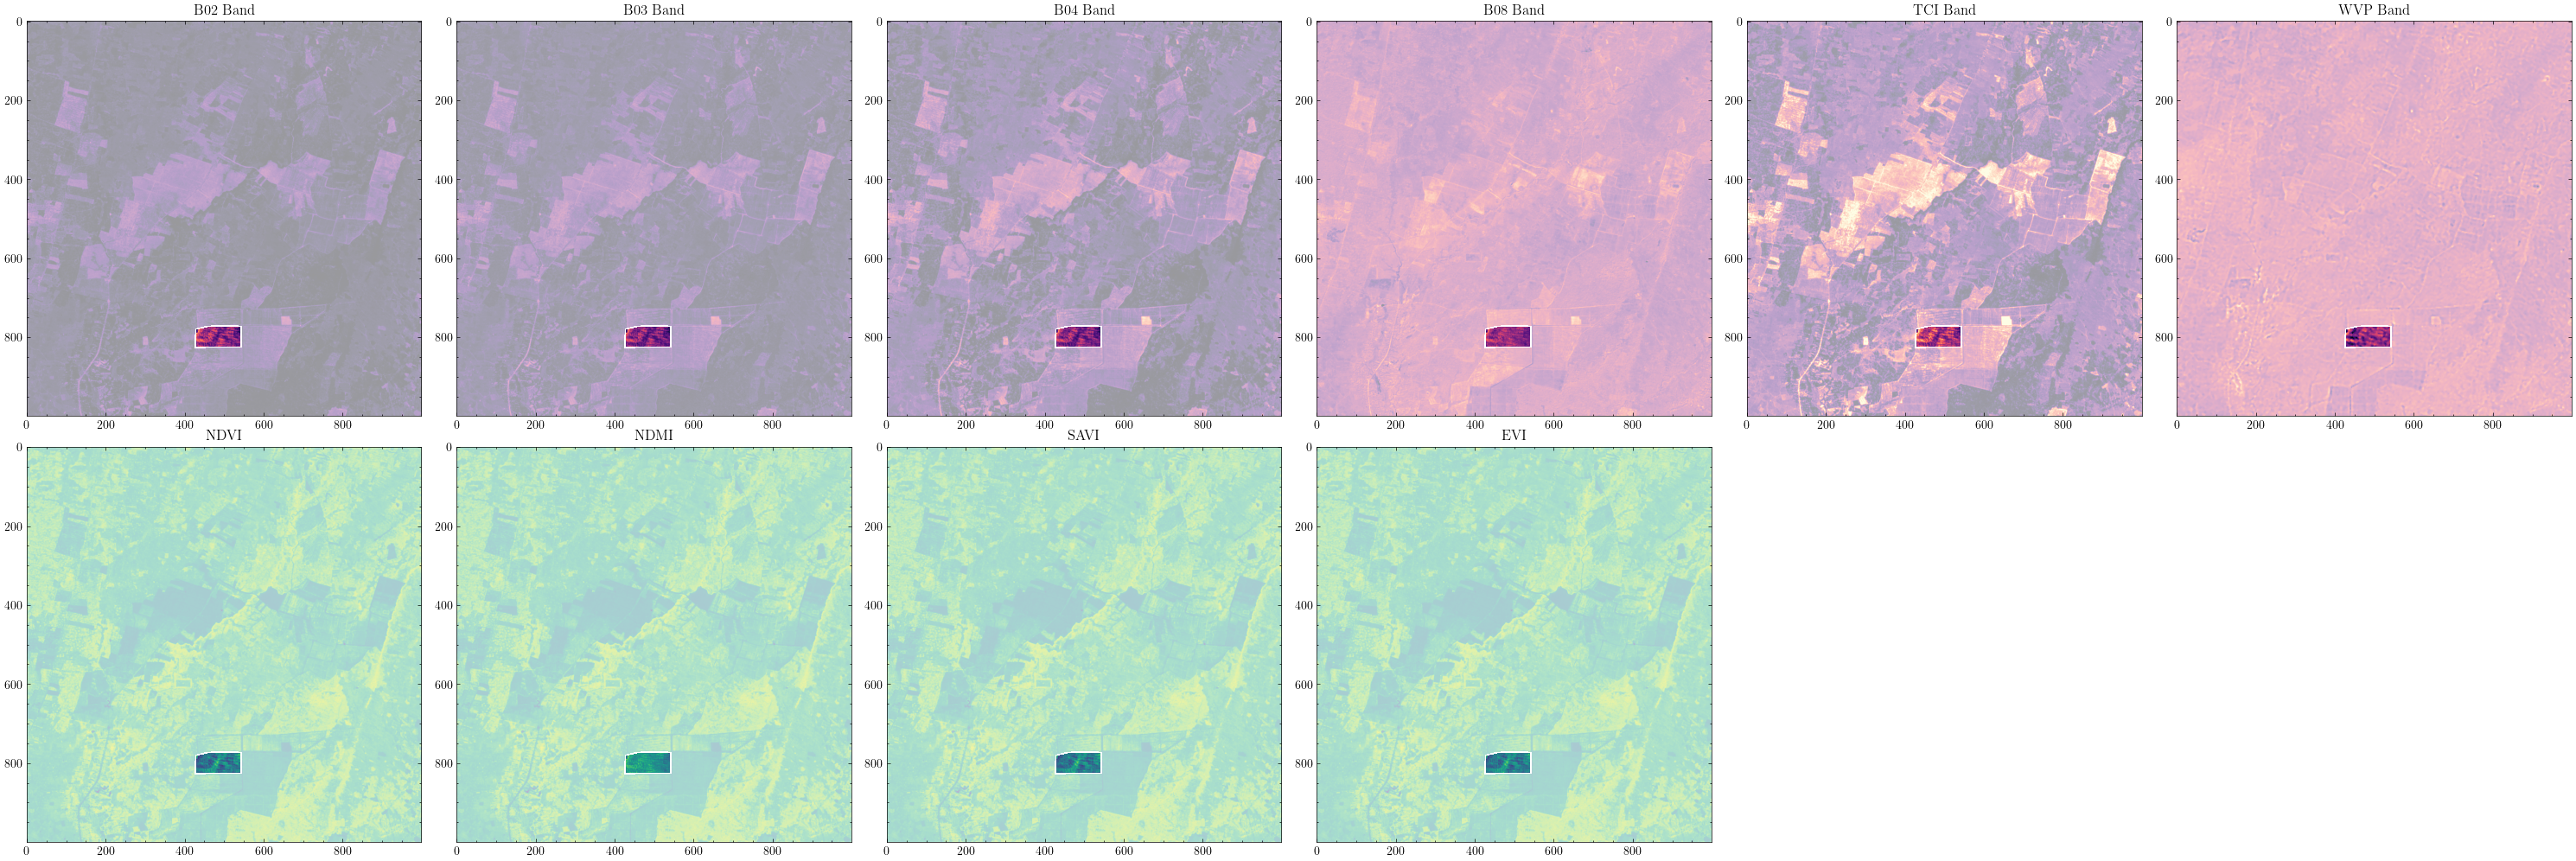

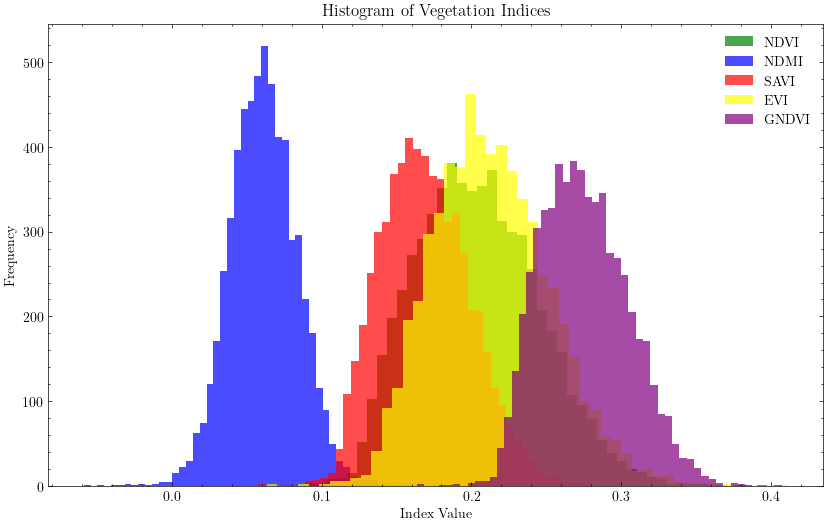

{
 "ndvi": {
  "mean": 0.20378953218460083,
  "min": 0.06327799707651138,
  "max": 0.3974200487136841,
  "std": 0.04110993444919586
 },
 "ndmi": {
  "mean": 0.06140042841434479,
  "min": -0.0588998943567276,
  "max": 0.16905716061592102,
  "std": 0.022502660751342773
 },
 "savi": {
  "mean": 0.1690606325864792,
  "min": 0.05758337676525116,
  "max": 0.31649309396743774,
  "std": 0.029988013207912445
 },
 "evi": {
  "mean": 0.2132682204246521,
  "min": 0.06350196152925491,
  "max": 0.41155800223350525,
  "std": 0.039120130240917206
 },
 "gndvi": {
  "mean": 0.27521729469299316,
  "min": 0.16345059871673584,
  "max": 0.40711742639541626,
  "std": 0.0292556993663311,
  "percentiles": {
   "25th": 0.25307440757751465,
   "50th": 0.2730683237314224,
   "75th": 0.29536255449056625
  }
 },
 "field_area": {
  "pixels": 6018,
  "square_meters": 601800,
  "hectares": 60.18
 },
 "canopy_cover": {
  "percentage": 1.3958125623130608
 }
}


In [5]:
print(process_granule(granule_path))